In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from linear_sca import *
from utils import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
import wandb

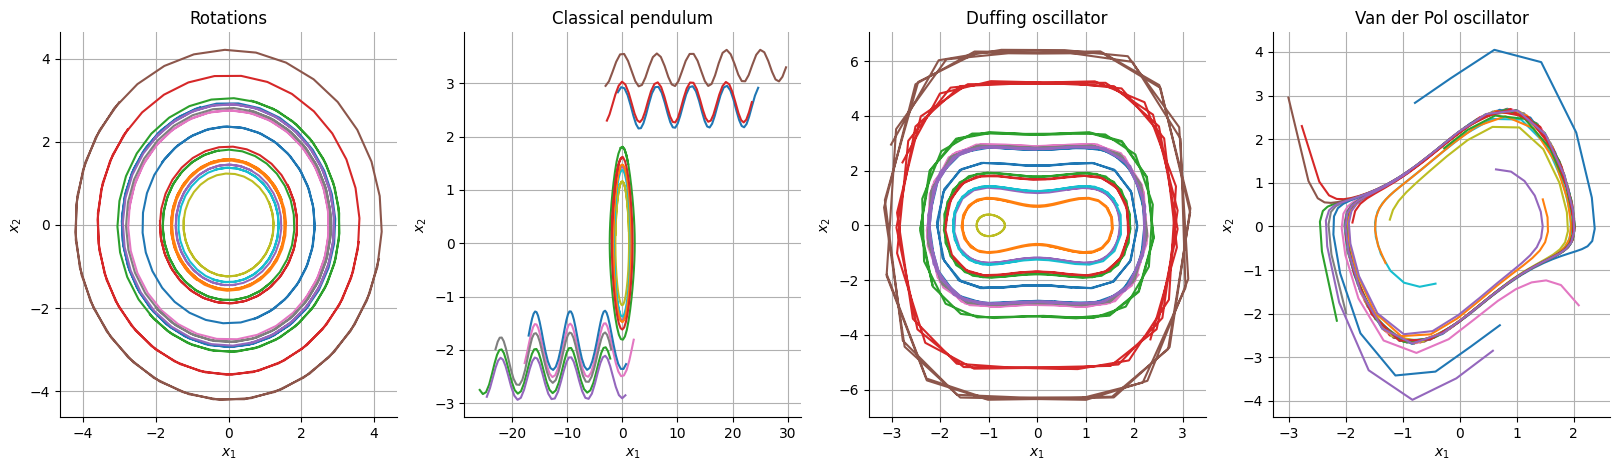

In [2]:
def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - x2 
    dx2_dt = x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]


t_span = (0, 10)                                    # simulate from t=0 to t=10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 50)     # time points where the solution is computed


num_trajectories = 15

seed = 42
np.random.seed(seed) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(num_trajectories, 2))

fig, axs = plt.subplots(1, 4, figsize=(20, 5))


for initial_conditions in initial_conditions_list:
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[0].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[0].set_title('Rotations')

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(pendulum_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[1].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[1].set_title('Classical pendulum')

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(duffing_oscillator, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[2].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[2].set_title('Duffing oscillator')

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(van_der_pol, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[3].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[3].set_title('Van der Pol oscillator')

for ax in axs:
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.grid()
    ax.spines[['right', 'top']].set_visible(False)


(15, 10, 50)


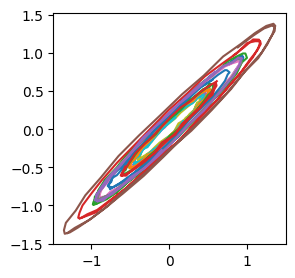

In [3]:

#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
X = np.zeros((num_trajectories, 2, len(t_eval)))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2
X = jnp.array(X)

# S_index = np.mean(compute_S(X, iterations=100))
# print(S_index)

seed = 42
key = random.PRNGKey(seed)
key, subkey = random.split(key)

proj_dims = 10
proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)

X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
print(X.shape)

noise = random.normal(subkey, (X.shape)) 
X += (noise)  /100
X = jnp.array(X)
K, N, T = X.shape

plt.figure(figsize=(3,3))
for i,initial_conditions in enumerate(initial_conditions_list):
    plt.plot(X[i,0,:],X[i,10,:] )

X, _ = pre_processing(X, pca=False, soft_normalize=False)

In [4]:
wandb.init(project="SCA-project-toydata", name="run_1", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(X[5:], d=2, learning_rate=0.01, iterations=500) 
wandb.finish

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 0.5589327812194824, S_ratio: 0.2819049060344696
Iteration 10, S: 1.7607253789901733, S_ratio: 0.2739073932170868
Iteration 20, S: 3.1282997131347656, S_ratio: 0.3698037564754486
Iteration 30, S: 7.060078144073486, S_ratio: 0.3522738814353943
Iteration 40, S: 12.85324478149414, S_ratio: 0.37879738211631775
Iteration 50, S: 19.752012252807617, S_ratio: 0.33673095703125
Iteration 60, S: 28.068326950073242, S_ratio: 0.3289231061935425
Iteration 70, S: 32.95014572143555, S_ratio: 0.352154016494751
Iteration 80, S: 38.3851318359375, S_ratio: 0.4663355052471161
Iteration 90, S: 50.62594985961914, S_ratio: 0.4164183437824249
Iteration 100, S: 53.09828567504883, S_ratio: 0.3869449496269226
Iteration 110, S: 59.96920394897461, S_ratio: 0.37364697456359863
Iteration 120, S: 42.483455657958984, S_ratio: 0.4837716519832611
Iteration 130, S: 47.95734786987305, S_ratio: 0.5264427065849304
Iteration 140, S: 51.14016342163086, S_ratio: 0.4547582268714905
Iteration 150, S: 62.90536117553

<function wandb.sdk.wandb_run.finish(exit_code: Optional[int] = None, quiet: Optional[bool] = None) -> None>

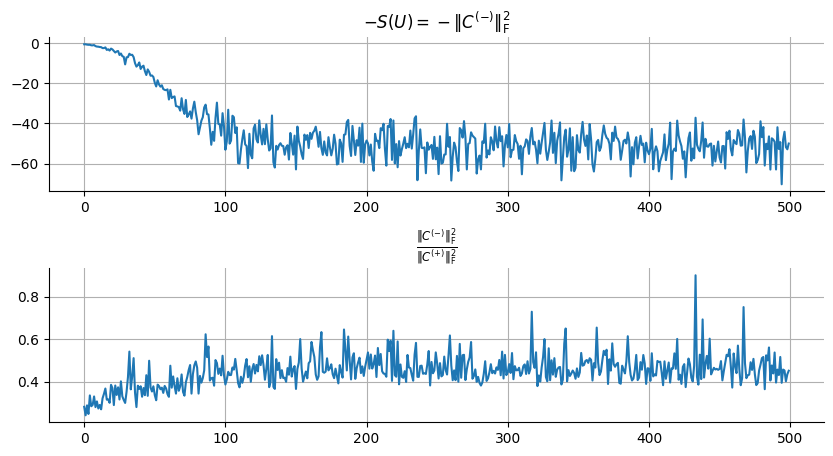

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)


0.6825657


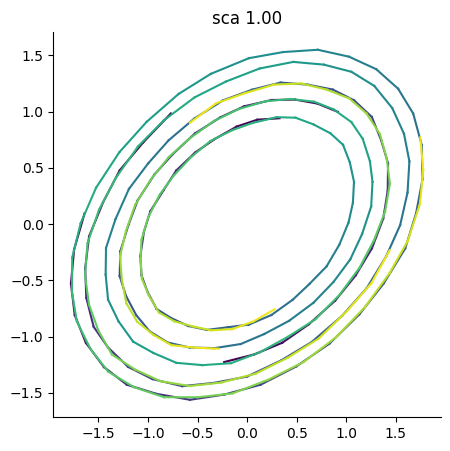

In [6]:
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X[:5])
plot_2D(Y)
plt.title(f"sca {var_explained(X[:5], U_qr):.2f}")

S_index = np.mean(compute_S(Y, iterations=100))
print(S_index)

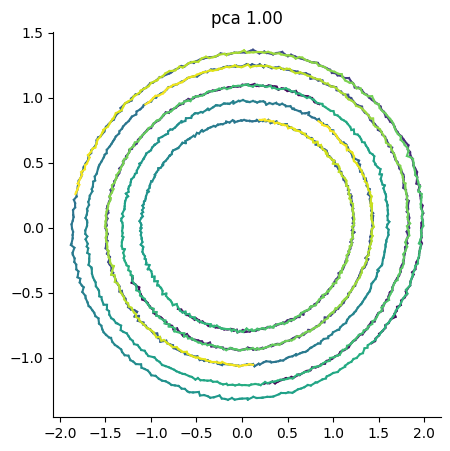

<Figure size 640x480 with 0 Axes>

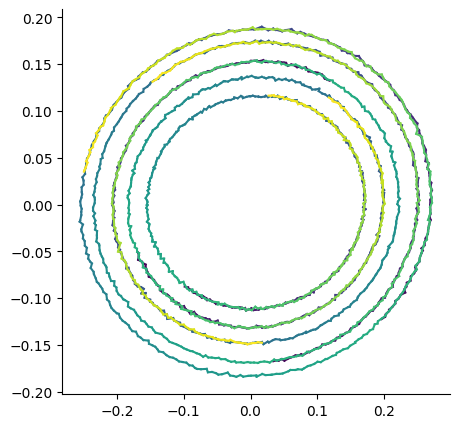

In [11]:
""" PCA """
split = 5
X_train = np.concatenate(X[split:].swapaxes(1,2))
X_test = np.concatenate(X[:split].swapaxes(1,2))
full_data_var = np.sum(np.var(X_test, axis=0))

num_pcs = 2
pca = PCA(num_pcs)
X_pca = pca.fit(X_train).transform(X_test)
PCs = pca.components_
X_pca = X_pca.reshape(-1, len(t_eval), num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(X_pca)
plt.title(f"pca {var_explained(X[:split], PCs[:2].T):.2f}")


kernel_pca = KernelPCA(
    n_components=2, kernel="rbf", gamma=1e-2
)
X_kernel_pca = kernel_pca.fit(X_train).transform(X_test)
X_kernel_pca = X_kernel_pca.reshape(-1, len(t_eval), num_pcs).swapaxes(1,2)
plt.figure()
plot_2D(X_kernel_pca)

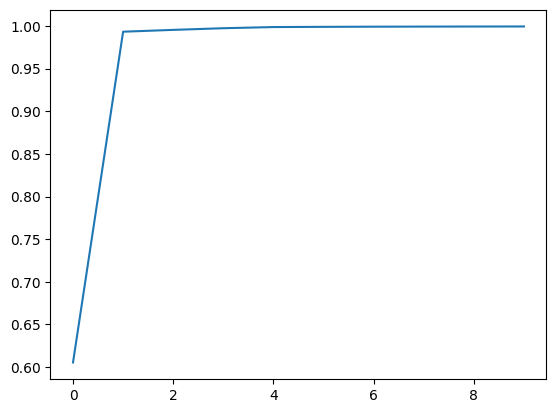

In [23]:
plt.plot(np.cumsum(pca_variance_captured))